# Noise, Spatial Filters and Frequency Analysis – Exercises 

Digital Signal and Image Processing – notebook 2

Luca Calatroni
luca.calatroni@unige.it

In this notebook we will:

1. Generate different kinds of noise on grayscale images:
   - Gaussian noise
   - Salt & pepper noise
   - Random (impulsive) noise

2. Add Gaussian noise to RGB images:
   - independently on each channel
   - only on a single channel

3. Compute the Signal-to-Noise Ratio (SNR) and the Peak-SNR (PSNR) *manually* and compare with standard Python routines.

4. Implement averaging (mean) filtering **manually** with two different window sizes and apply it to noisy images.

5. Apply an edge detector (discrete Laplacian) and a sharpening filter.

6. Study all of the above in the **frequency domain**:
   - power spectrum of white Gaussian noise
   - 2D FFT of noisy images
   - 2D FFT of filtered images (averaging and sharpening)

7. Implement Gaussian filtering:
   - in the spatial domain (convolution with a Gaussian kernel)
   - in the frequency domain (multiplication in the Fourier domain).

+ Project assignments


In [41]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data, img_as_float  # consider using img_as_float to convert images to float
from skimage.metrics import peak_signal_noise_ratio

plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams["image.cmap"] = "gray"

Throughout the notebook we will work with images normalized in `[0, 1]` (`float64`): this is needed to deal with noise (otherwise, rounding is required --> quantization errors)

## 1. Noise generation on a grayscale image

### 1.1 Load a grayscale image

(512, 512) float64


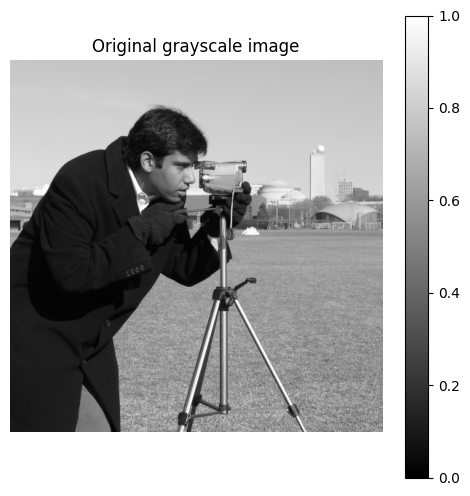

In [42]:
# Use the standard "camera" image as grayscale test image
img_gray = img_as_float(data.camera())

print(img_gray.shape, img_gray.dtype)

plt.imshow(img_gray)
plt.title("Original grayscale image")
plt.colorbar()
plt.axis("off")
plt.show()

### 1.2 Additive Gaussian noise

We model noise as $I_{\text{obs}} = I + n$, with $n \sim \mathcal{N}(0, \sigma^2)$.

**TODO**: Complete the function below to add zero-mean Gaussian noise with standard deviation sigma to the image. Use `np.random.normal()` to generate the noise and remember to clip the result to the valid range [0, 1].

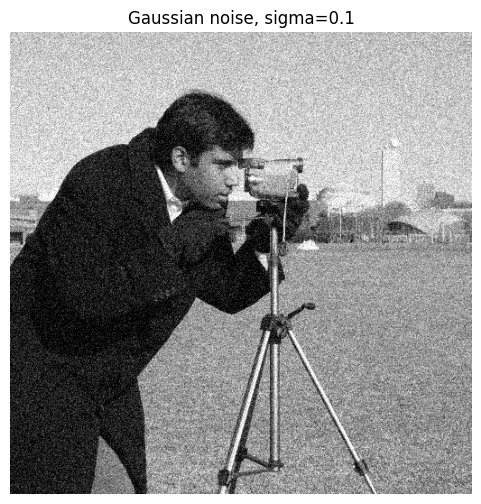

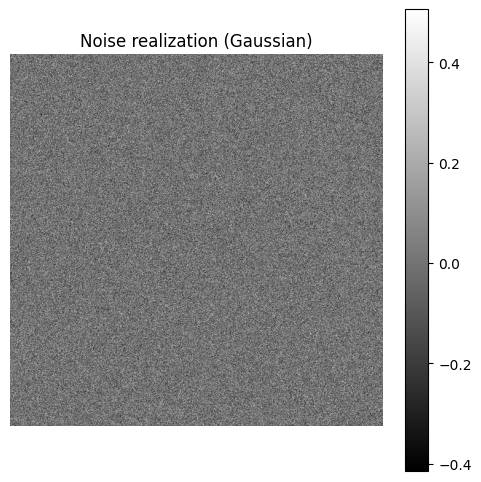

In [43]:
def add_gaussian_noise(image, sigma):
    """Add zero-mean Gaussian noise with standard deviation sigma to the image."""
    # TODO: Generate noise using np.random.normal(loc=..., scale=..., size=...)
    noise = np.random.normal(loc=0.0, scale=sigma, size=image.shape)
    
    # TODO: Add noise to image
    noisy = image + noise

    # TODO: Clip to valid range 
    noisy = np.clip(noisy, 0.0, 1.0)
    
    return noisy, noise

sigma = 0.1
img_gauss, noise_gauss = add_gaussian_noise(img_gray, sigma)

plt.figure()
plt.imshow(img_gauss)
plt.title(f"Gaussian noise, sigma={sigma}")
plt.axis("off")
plt.show()

# Also visualize the generated noise image
plt.figure()
plt.imshow(noise_gauss)
plt.title("Noise realization (Gaussian)")
plt.colorbar()
plt.axis("off")
plt.show()


### 1.3 Salt & pepper noise

For probability $p$:

$$
I_{\text{S\&P}}[i,j] =
\begin{cases}
0   & \text{with prob. } p/2 \\
1   & \text{with prob. } p/2 \\
I[i,j] & \text{with prob. } 1-p
\end{cases}
$$

**TODO**: Complete the function below to add salt & pepper noise. Use `np.random.rand()` to generate random values, then set pixels to 0 (pepper) with probability p/2 and to 1 (salt) with probability p/2.

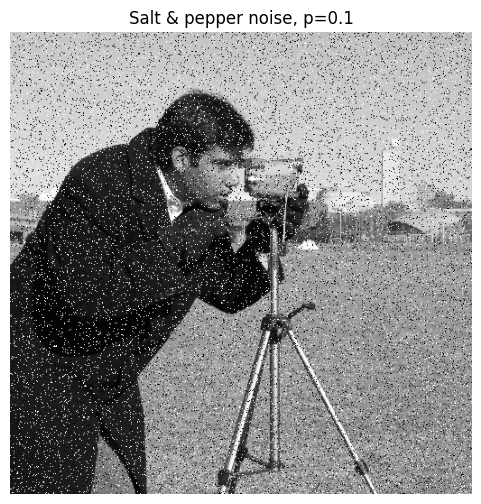

In [44]:
def add_salt_and_pepper_noise(image, p=0.05):
    """
    Apply salt & pepper noise to a grayscale image according to the definition.
    Assumes grayscale image values in [0, 1].
    """
    noisy = image.copy()

    # Per-pixel random map (H, W) with values in [0, 1]
    rnd = np.random.rand(*image.shape)

    # Masks according to probabilities

    # TODO: create mask for salt noise
    mask_salt = rnd < p/2

    # TODO: create mask for pepper noise
    mask_pepper = (rnd >= p/2) & (rnd < p)

    # TODO: assign salt/pepper values
    noisy[mask_salt] = 1.0
    noisy[mask_pepper] = 0.0

    return noisy

p = 0.1
img_sp = add_salt_and_pepper_noise(img_gray, p=p)

plt.figure()
plt.imshow(img_sp)
plt.title(f"Salt & pepper noise, p={p}")
plt.axis("off")
plt.show()

### 1.4 Random (impulse) noise

With probability $p$ a pixel is replaced by a uniform random value in $[0,1]$.

**TODO**: Complete the function below to add random impulsive noise. Generate a mask of pixels to corrupt (probability p), then replace those pixels with uniform random values in [0,1].

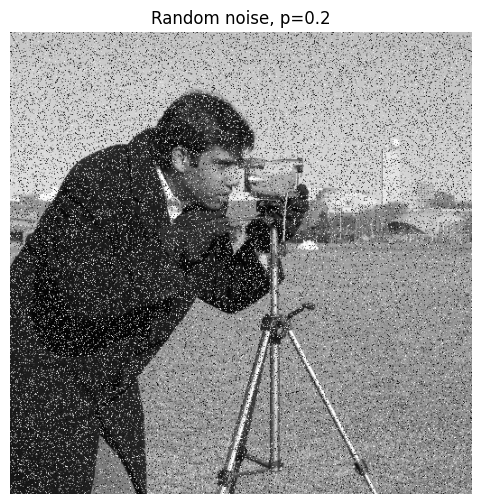

In [45]:
def add_random_noise(image, p=0.1):
    noisy = image.copy()
    
    # TODO: Generate random values for selecting pixels to corrupt
    rnd = np.random.rand(*image.shape)
    
    # TODO: Create a mask where rnd < p
    mask = rnd < p
    
    # TODO: Generate random values in [0, 1] for replacement
    random_values = np.random.rand(np.sum(mask))
    
    # TODO: Replace pixels according to mask
    noisy[mask] = random_values
    
    return noisy

p = 0.2
img_random = add_random_noise(img_gray, p=p)

plt.figure()
plt.imshow(img_random)
plt.title(f"Random noise, p={p}")
plt.axis("off")
plt.show()

## 2. Gaussian noise on RGB images

A common model for RGB AWGN is:

$$
I_{\text{obs}}[i,j] = I[i,j] + n[i,j], \quad
n[i,j] =
\begin{bmatrix}
n_R \\
n_G \\
n_B
\end{bmatrix}
\sim \mathcal{N}(0, \sigma^2 I_3)
$$

### 2.1 Load an RGB image

(512, 512, 3) float64


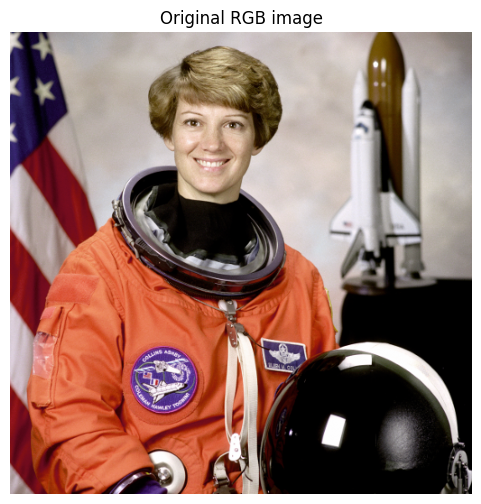

In [46]:
img_rgb = img_as_float(data.astronaut())
print(img_rgb.shape, img_rgb.dtype)

plt.imshow(img_rgb)
plt.title("Original RGB image")
plt.axis("off")
plt.show()

### 2.2 Add Gaussian noise to all channels independently

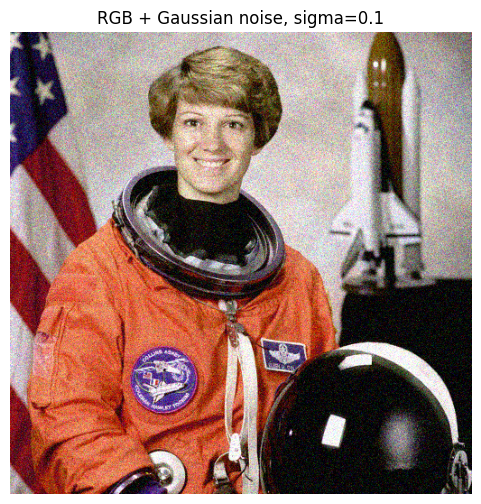

In [47]:
def add_gaussian_noise_rgb(image, sigma):
    noise = np.random.normal(0.0, sigma, size=image.shape)
    noisy = image + noise
    return np.clip(noisy, 0.0, 1.0), noise

sigma_rgb = 0.1
img_rgb_gauss, noise_rgb = add_gaussian_noise_rgb(img_rgb, sigma_rgb)

plt.figure()
plt.imshow(img_rgb_gauss)
plt.title(f"RGB + Gaussian noise, sigma={sigma_rgb}")
plt.axis("off")
plt.show()

### 2.3 Add Gaussian noise only to one channel (e.g. blue)

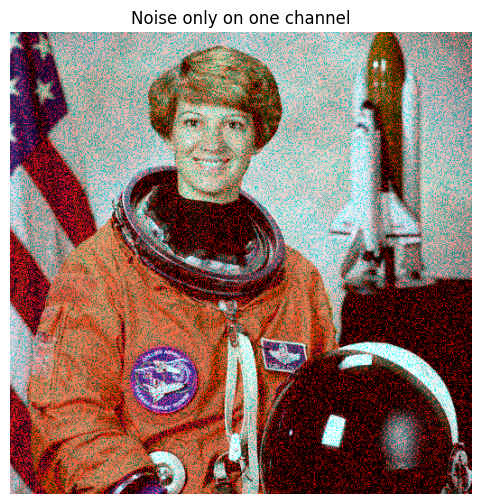

In [48]:
def add_gaussian_noise_single_channel(image, sigma, channel=2):
    noisy = image.copy()
    noise = np.random.normal(0.0, sigma, size=image.shape[:2])
    noisy[..., channel] += noise
    return np.clip(noisy, 0.0, 1.0), noise

sigma_blue = 0.5
img_rgb_blue, noise_blue = add_gaussian_noise_single_channel(img_rgb, sigma_blue, channel=0)

plt.figure()
plt.imshow(img_rgb_blue)
plt.title("Noise only on one channel")
plt.axis("off")
plt.show()

## 3. Signal-to-Noise Ratio (SNR)

We define

$$
\text{SNR} = \frac{\|I\|_2}{\|n\|_2}, \qquad
\text{SNR}_{\text{dB}} = 20 \log_{10} \left( \frac{\|I\|_2}{\|n\|_2} \right),
$$

where $n = I_{\text{obs}} - I$.

### 3.1 Manual SNR computation

**TODO**: Complete the function below to compute SNR in dB. Calculate the noise as the difference between noisy and clean images, then compute their L2 norms and apply the formula above.

In [49]:
def compute_snr_db(clean, noisy):
    clean = clean.astype(np.float64)
    noisy = noisy.astype(np.float64)
    
    # TODO: Compute noise as difference
    noise = noisy - clean

    # TODO: Compute L2 norm of clean signal using np.linalg.norm(...)
    signal_norm = np.linalg.norm(clean)
    
    # TODO: Compute L2 norm of noise
    noise_norm = np.linalg.norm(noise)

    # TODO: Compute SNR in linear scale and convert to dB
    snr_linear = signal_norm / noise_norm
    snr_db = 20 * np.log10(snr_linear)
    
    return snr_db


# Create multiple noisy versions (different sigmas)
sigmas = [0.02, 0.05, 0.1, 0.2]
noisy_versions = []
snrs_db = []

for s in sigmas:
    noisy, _ = add_gaussian_noise(img_gray, sigma=s)
    noisy_versions.append(noisy)
    snrs_db.append(compute_snr_db(img_gray, noisy))

for s, snr in zip(sigmas, snrs_db):
    print(f"sigma={s:.3f} -> SNR = {snr:.2f} dB")

sigma=0.020 -> SNR = 29.34 dB
sigma=0.050 -> SNR = 21.48 dB
sigma=0.100 -> SNR = 15.73 dB
sigma=0.200 -> SNR = 10.34 dB


**TODO**: Complete the function below to compute PSNR in dB manually. Use the formula:

$$
\text{PSNR} = 20 \log_{10} \left( \frac{\text{MAX}_I}{\text{RMSE}} \right)
$$

where MAX_I is the maximum possible pixel value (data_range) and RMSE is the root mean squared error.

In [50]:
def compute_psnr_db(clean, noisy, data_range=1.0):
    """
    Manually compute Peak Signal-to-Noise Ratio (PSNR) in dB.
    
    PSNR = 20 * log10(MAX_I / RMSE)
    where MAX_I is the maximum possible pixel value
    and RMSE is the root mean squared error between clean and noisy images.
    """
    clean = clean.astype(np.float64)
    noisy = noisy.astype(np.float64)
    
    # TODO: Compute mean squared error (MSE)
    mse = np.mean((clean - noisy) ** 2)
    
    if mse == 0:
        return float('inf')  # Perfect match
    
    # TODO: Compute PSNR in dB
    psnr = 20 * np.log10(data_range / np.sqrt(mse))
    
    return psnr

### 3.2 Comparison with standard Python routine (PSNR)

In [51]:
for s, noisy in zip(sigmas, noisy_versions):
    snr_db = compute_snr_db(img_gray, noisy)
    psnr_manual = compute_psnr_db(img_gray, noisy, data_range=1.0)
    psnr_skimage = peak_signal_noise_ratio(img_gray, noisy, data_range=1.0)
    print(f"sigma={s:.3f} -> SNR={snr_db:6.2f} dB,  PSNR (manual)={psnr_manual:6.2f} dB,  PSNR (skimage)={psnr_skimage:6.2f} dB")

sigma=0.020 -> SNR= 29.34 dB,  PSNR (manual)= 34.04 dB,  PSNR (skimage)= 34.04 dB
sigma=0.050 -> SNR= 21.48 dB,  PSNR (manual)= 26.17 dB,  PSNR (skimage)= 26.17 dB
sigma=0.100 -> SNR= 15.73 dB,  PSNR (manual)= 20.42 dB,  PSNR (skimage)= 20.42 dB
sigma=0.200 -> SNR= 10.34 dB,  PSNR (manual)= 15.03 dB,  PSNR (skimage)= 15.03 dB


## 4. Manual averaging (mean) filtering

We implement 2D convolution by hand and apply it with two different window sizes.

### 4.1 Manual 2D convolution for a single-channel image

**TODO**: Complete the double for loop below to compute the 2D convolution. For each output pixel (i,j), extract the corresponding patch from the padded image and compute the weighted sum with the kernel.

In [52]:
def conv2d_manual(image, kernel):
    """
    Simple 2D convolution (valid for grayscale images).
    Zero-padding, correlation-style (no kernel flip, which is fine for symmetric kernels).
    """
    image = image.astype(np.float64)
    kH, kW = kernel.shape
    pad_h = kH // 2
    pad_w = kW // 2

    padded = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode="edge")
    out = np.zeros_like(image, dtype=np.float64)

    # TODO: Complete the double for loop
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            # TODO: Extract the patch from padded image
            patch = padded[i:i + kH, j:j + kW]
            
            # TODO: Compute convolution using the formula as weighted sum (element-wise multiplication and sum)
            out[i, j] = np.sum(patch * kernel)

    return out

### 4.2 Build averaging kernels of different sizes

In [53]:
def averaging_kernel(size):
    k = np.ones((size, size), dtype=np.float64)
    k /= k.size
    return k

kernel_3 = averaging_kernel(3)
kernel_9 = averaging_kernel(9)

print("3x3 kernel sum:", kernel_3.sum())
print("9x9 kernel sum:", kernel_9.sum())

3x3 kernel sum: 1.0
9x9 kernel sum: 1.0


### 4.3 Apply averaging filters to a noisy image

**TODO**: Use your `conv2d_manual` function to apply both 3x3 and 9x9 averaging kernels to the noisy image. Display the results and compare the SNR values.

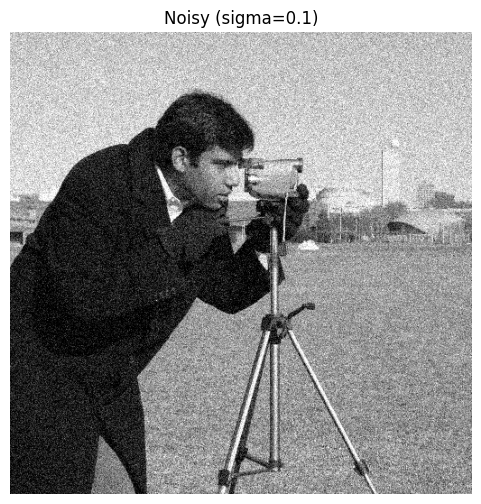

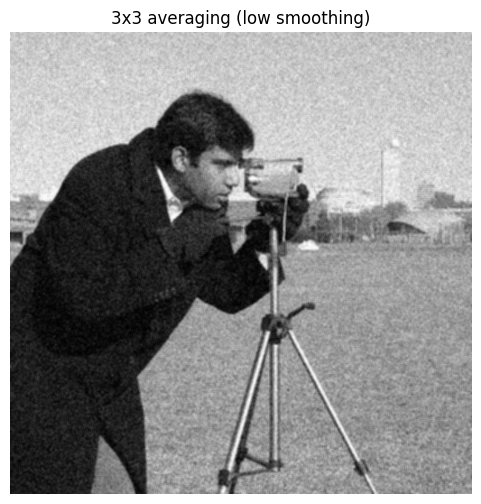

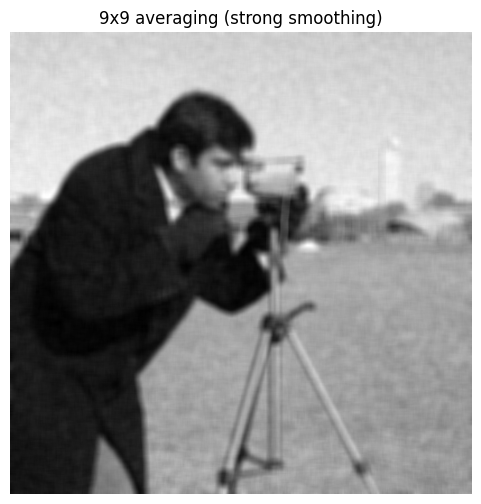

Noisy SNR: 15.75967347835061
After 3x3 mean: 21.854801303796656
After 9x9 mean: 19.039022010268667


In [54]:
# Use a grayscale image corrupted by Gaussian noise
sigma_avg = 0.1
img_noisy_avg, _ = add_gaussian_noise(img_gray, sigma_avg)

# TODO: Apply 3x3 averaging filter
img_mean_3 = conv2d_manual(img_noisy_avg, kernel_3)

# TODO: Apply 9x9 averaging filter
img_mean_9 = conv2d_manual(img_noisy_avg, kernel_9)

plt.figure()
plt.imshow(img_noisy_avg)
plt.title(f"Noisy (sigma={sigma_avg})")
plt.axis("off")
plt.show()

plt.figure()
plt.imshow(img_mean_3)
plt.title("3x3 averaging (low smoothing)")
plt.axis("off")
plt.show()

plt.figure()
plt.imshow(img_mean_9)
plt.title("9x9 averaging (strong smoothing)")
plt.axis("off")
plt.show()

print("Noisy SNR:", compute_snr_db(img_gray, img_noisy_avg))
print("After 3x3 mean:", compute_snr_db(img_gray, img_mean_3))
print("After 9x9 mean:", compute_snr_db(img_gray, img_mean_9))

## 5. Edge detector and sharpening filter

We use the kernels:

- Edge detector (discrete Laplacian)
- Sharpening filter $h_{\text{sharp}} = \text{Id} + h_{\text{edge}}$

### 5.1 Define kernels and a generic convolution wrapper

**TODO**: Define the edge detection kernel (discrete Laplacian) and the sharpening kernel. The Laplacian should have -1 on the sides, 4 in the center, and 0 on the corners. The sharpening kernel is identity + edge detector.

In [55]:
# TODO: Define the edge detection kernel (discrete Laplacian) writing eplicitly down the values of the array
# hedge = np.array(...., dtype=np.float64)
hedge = np.array([[0.0,-1.0,0.0],[-1.0,4.0,-1.0],[0.0,-1.0,0.0]], dtype=np.float64)

# TODO: Define the sharpening kernel (identity + edge detector) writing eplicitly down the values of the array
# hsharp = np.array(...., dtype=np.float64)
hsharp = np.array([[0.0,-1.0,0.0],[-1.0,5.0,-1.0],[0.0,-1.0,0.0]], dtype=np.float64)

def apply_filter_gray(image, kernel):
    return conv2d_manual(image, kernel)

### 5.2 Apply edge detector and sharpening to a (noisy) image

**TODO**: Apply your edge detection and sharpening filters to a noisy image (with low noise level, sigma=0.01). Display the results.

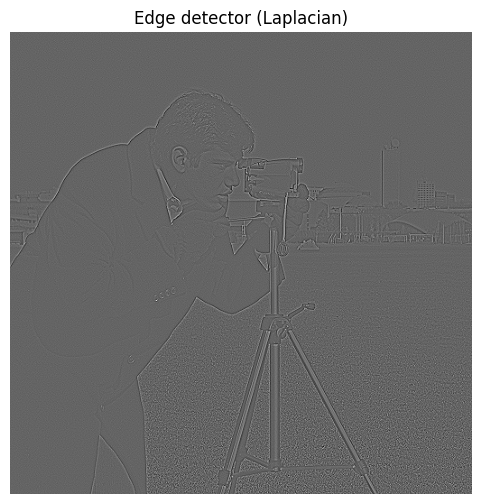

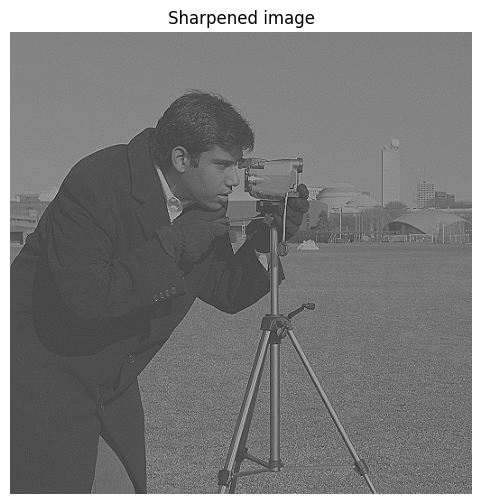

In [56]:
sigma_edge = 0.01
img_noisy_edge, _ = add_gaussian_noise(img_gray, sigma_edge)

# TODO: Apply edge detector
img_edge = apply_filter_gray(img_noisy_edge, hedge)

# TODO: Apply sharpening filter
img_sharp = apply_filter_gray(img_noisy_edge, hsharp)

plt.figure()
plt.imshow(img_edge)
plt.title("Edge detector (Laplacian)")
plt.axis("off")
plt.show()

plt.figure()
plt.imshow(img_sharp)
plt.title("Sharpened image")
plt.axis("off")
plt.show()

## 6. Frequency-domain analysis

We study:

- the power spectrum of Gaussian noise,
- the 2D FFT of a noisy image,
- the 2D FFT of images after mean filtering and sharpening.

### 6.1 Helper to compute and display magnitude spectrum

In [57]:
def compute_magnitude_spectrum(image):
    """Compute log-magnitude spectrum of a 2D real image."""
    F = np.fft.fft2(image)
    F_shift = np.fft.fftshift(F)
    magnitude = np.log1p(np.abs(F_shift))
    return magnitude

def compute_power_spectrum(image):
    """Compute log-power spectrum of a 2D real image."""
    F = np.fft.fft2(image)
    F_shift = np.fft.fftshift(F)
    power = np.abs(F_shift) ** 2  # Power = |F|^2
    log_power = np.log1p(power)
    return log_power

def show_spectrum(image, title="", spectrum_type="magnitude"):
    if spectrum_type == "power":
        spectrum = compute_power_spectrum(image)
    else:
        spectrum = compute_magnitude_spectrum(image)
    plt.figure()
    plt.imshow(spectrum)
    plt.title(title)
    plt.colorbar()
    plt.axis("off")
    plt.show()

### 6.2 Power spectrum of Gaussian noise

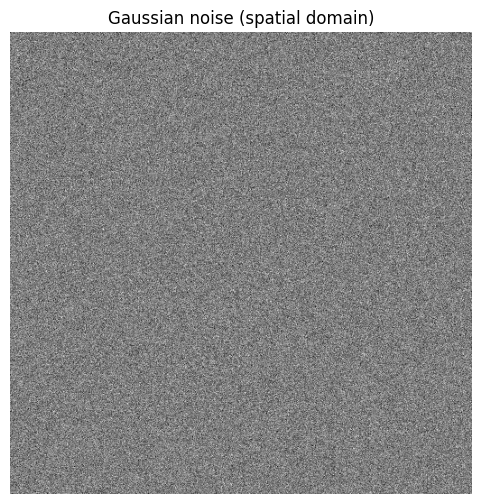

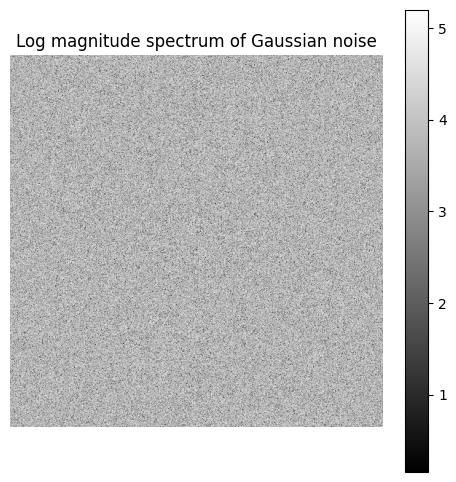

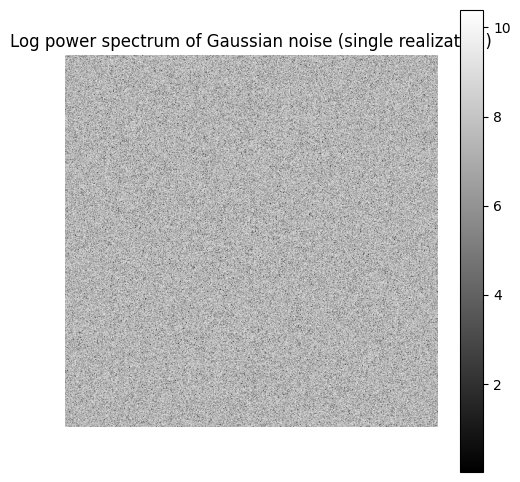

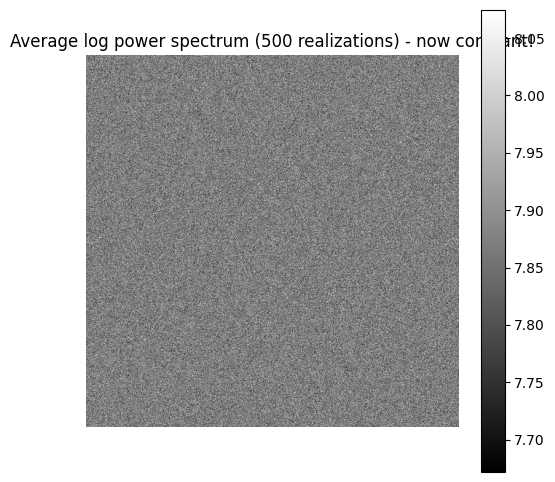

Std of averaged power spectrum: 117.21
Mean of averaged power spectrum: 2621.43
Coefficient of variation: 0.0447 (should be small)


In [58]:
M, N = img_gray.shape
noise_only = np.random.normal(0.0, 0.1, size=(M, N))

plt.figure()
plt.imshow(noise_only)
plt.title("Gaussian noise (spatial domain)")
plt.axis("off")
plt.show()

show_spectrum(noise_only, title="Log magnitude spectrum of Gaussian noise", spectrum_type="magnitude")
show_spectrum(noise_only, title="Log power spectrum of Gaussian noise (single realization)", spectrum_type="power")

# Average power spectrum over many realizations to see the constant property
num_realizations = 500
avg_power = np.zeros((M, N))

for _ in range(num_realizations):
    noise = np.random.normal(0.0, 0.1, size=(M, N))
    F = np.fft.fft2(noise)
    F_shift = np.fft.fftshift(F)
    avg_power += np.abs(F_shift) ** 2

avg_power /= num_realizations

plt.figure()
plt.imshow(np.log1p(avg_power))
plt.title(f"Average log power spectrum ({num_realizations} realizations) - now constant!")
plt.colorbar()
plt.axis("off")
plt.show()

print(f"Std of averaged power spectrum: {avg_power.std():.2f}")
print(f"Mean of averaged power spectrum: {avg_power.mean():.2f}")
print(f"Coefficient of variation: {avg_power.std()/avg_power.mean():.4f} (should be small)")

### 6.3 FFT of noisy and filtered images

**TODO**: Display the magnitude spectrum for:
1. An image filtered with 3x3 mean filter
2. An image after edge detection (Laplacian)

Use the helper function `show_spectrum()` provided above.

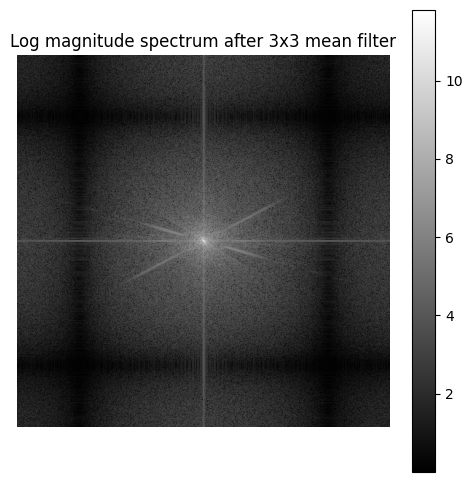

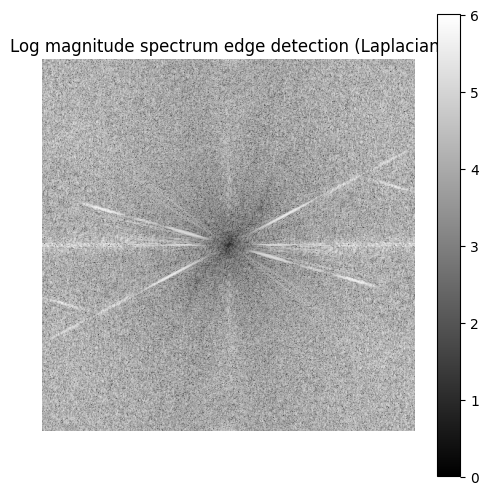

In [59]:
# TODO: Show spectrum for mean filtered image (img_mean_3)
show_spectrum(img_mean_3, title="Log magnitude spectrum after 3x3 mean filter", spectrum_type="magnitude")

# TODO: Show spectrum for edge detected image (img_edge)
show_spectrum(img_edge, title="Log magnitude spectrum edge detection (Laplacian)", spectrum_type="magnitude")

## 7. Gaussian filtering in spatial and frequency domain

### 7.1 Build a discrete 2D Gaussian kernel

**TODO**: Complete the function below to create a 2D Gaussian kernel. Use the formula:

$$
g(x, y) = \frac{1}{2\pi\sigma^2} \exp\left(-\frac{x^2 + y^2}{2\sigma^2}\right)
$$

Remember to normalize the kernel so that its sum equals 1.

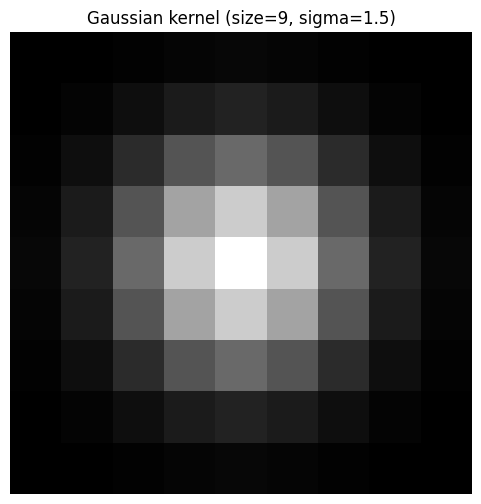

In [60]:
def gaussian_kernel_2d(size=7, sigma=1.0):
    """Create a 2D Gaussian kernel of given size and sigma. size should be odd."""
    k = size // 2
    
    x = np.arange(-k, k+1)
    y = np.arange(-k, k+1)
    X, Y = np.meshgrid(x, y)
    
    # TODO: Compute Gaussian function
    g = (1/(2*np.pi*sigma**2)) * np.exp(-(X**2 + Y**2)/(2*sigma**2))
    
    # TODO: Normalize so sum equals 1
    g = g / g.sum()
    
    return g

g_size = 9
g_sigma = 1.5
g_kernel = gaussian_kernel_2d(size=g_size, sigma=g_sigma)

plt.figure()
plt.imshow(g_kernel)
plt.title(f"Gaussian kernel (size={g_size}, sigma={g_sigma})")
plt.axis("off")
plt.show()

### 7.2 Gaussian filtering in the spatial domain (via convolution)

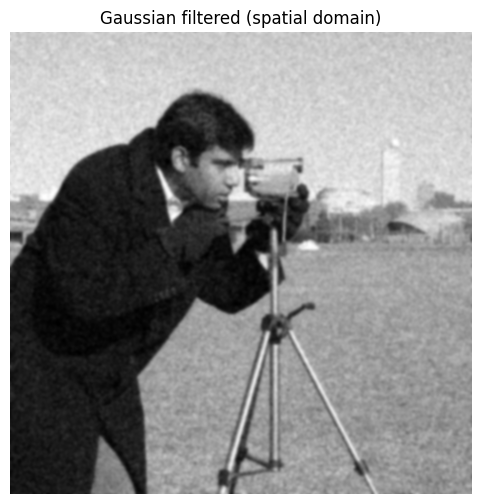

SNR after Gaussian filter: 21.752604095506392


In [61]:
img_gauss_filt_spatial = conv2d_manual(img_noisy_avg, g_kernel)

plt.figure()
plt.imshow(img_gauss_filt_spatial)
plt.title("Gaussian filtered (spatial domain)")
plt.axis("off")
plt.show()

print("SNR after Gaussian filter:",
      compute_snr_db(img_gray, img_gauss_filt_spatial))

### 7.3 Gaussian filtering in the frequency domain

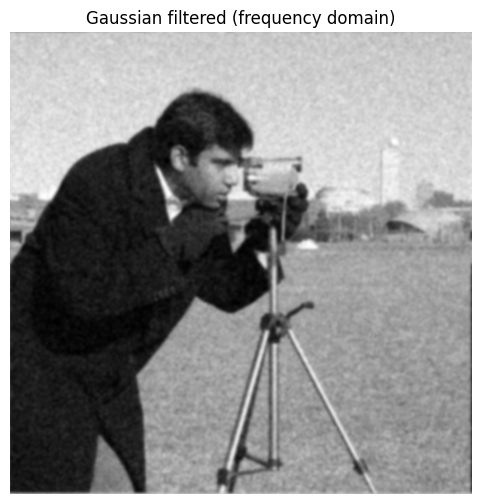

Difference between spatial and frequency results: 0.4886448927439014


In [62]:
def gaussian_filter_freq_domain(image, kernel):
    M, N = image.shape
    kH, kW = kernel.shape

    # Zero-pad kernel to image size, centering it
    pad = np.zeros((M, N), dtype=np.float64)
    
    # Place kernel at the center of the padded array
    start_h = (M - kH) // 2
    start_w = (N - kW) // 2
    pad[start_h:start_h + kH, start_w:start_w + kW] = kernel
    
    # Shift so that DC component is at (0,0) for FFT
    pad = np.fft.ifftshift(pad)

    F_img = np.fft.fft2(image)
    F_kernel = np.fft.fft2(pad)

    F_out = F_img * F_kernel
    img_filtered = np.real(np.fft.ifft2(F_out))

    return img_filtered

img_gauss_filt_freq = gaussian_filter_freq_domain(img_noisy_avg, g_kernel)

plt.figure()
plt.imshow(img_gauss_filt_freq)
plt.title("Gaussian filtered (frequency domain)")
plt.axis("off")
plt.show()

print("Difference between spatial and frequency results:",
      np.abs(img_gauss_filt_spatial - img_gauss_filt_freq).max())

### 7.4 Spectra of Gaussian filter and its effect

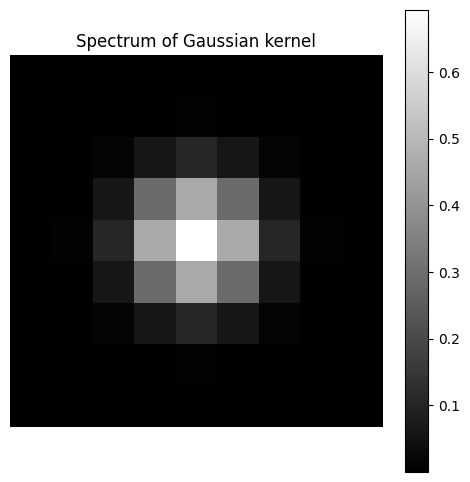

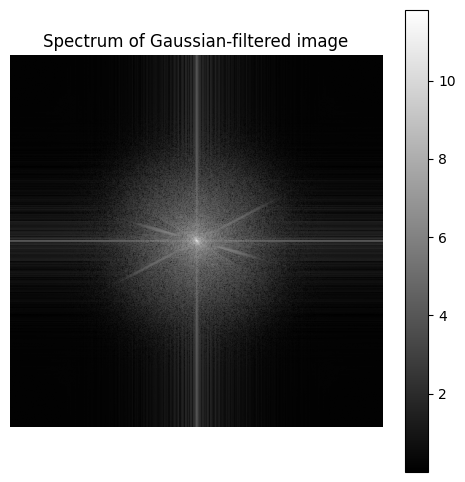

In [63]:
show_spectrum(g_kernel, "Spectrum of Gaussian kernel")
show_spectrum(img_gauss_filt_spatial, "Spectrum of Gaussian-filtered image")

## Project assignment, task 1/2: Median filtering for salt & pepper noise

Median filtering is particularly effective for removing salt & pepper noise compared to mean or Gaussian filters.
Write down functions implementing manually median filtering and apply to an image corrupted by low/high level of salt and pepper noise. Compare the result in terms of SNR with the one obtained by mean filtering (of different size). What do you observe?

## Project assignment, task 2/2: multiplicative noise removal via logarithmic transformation

Consider a multiplicative noise model $I_{\text{noisy}} = n \cdot I$ where $n$ is AWGN.
After forcing both n and I to be strictly positive, consider a suitable transformation that converts the model into an additive model and apply mean filtering on the transformed image. Re-transform back to get the image in correct domain.